In [1]:
# importar modulos

#manejo de datos
import pandas as pd
import numpy as np
import datetime
# Graficación
import matplotlib.pyplot as plt
import seaborn as sns
# Analisis de la serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Modelo
from pmdarima import auto_arima
# Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Serializacion del modelo
import pickle

In [1]:
import pandas as pd

# Asumiendo que los datos están en formato CSV
aquifer_auser = pd.read_csv('/workspaces/linea_temporal_alternativa/data/raw/Aquifer_Auser.csv')


In [5]:
# Cargar el conjunto de datos del acuífero Auser
auser_data = pd.read_csv('/workspaces/linea_temporal_alternativa/data/raw/Aquifer_Auser.csv')

# Mostrar las primeras filas del DataFrame y la información general
auser_data_info = auser_data.info()
auser_data_head = auser_data.head()

auser_data_info, auser_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     8154 non-null   object 
 1   Rainfall_Gallicano                       5295 non-null   float64
 2   Rainfall_Pontetetto                      5295 non-null   float64
 3   Rainfall_Monte_Serra                     5289 non-null   float64
 4   Rainfall_Orentano                        5295 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 6   Rainfall_Piaggione                       4930 non-null   float64
 7   Rainfall_Calavorno                       5295 non-null   float64
 8   Rainfall_Croce_Arcana                    5295 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico            5295 no

(None,
          Date  Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
 0  05/03/1998                 NaN                  NaN                   NaN   
 1  06/03/1998                 NaN                  NaN                   NaN   
 2  07/03/1998                 NaN                  NaN                   NaN   
 3  08/03/1998                 NaN                  NaN                   NaN   
 4  09/03/1998                 NaN                  NaN                   NaN   
 
    Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  Rainfall_Piaggione  \
 0                NaN                       NaN                 NaN   
 1                NaN                       NaN                 NaN   
 2                NaN                       NaN                 NaN   
 3                NaN                       NaN                 NaN   
 4                NaN                       NaN                 NaN   
 
    Rainfall_Calavorno  Rainfall_Croce_Arcana  \
 0                 NaN      

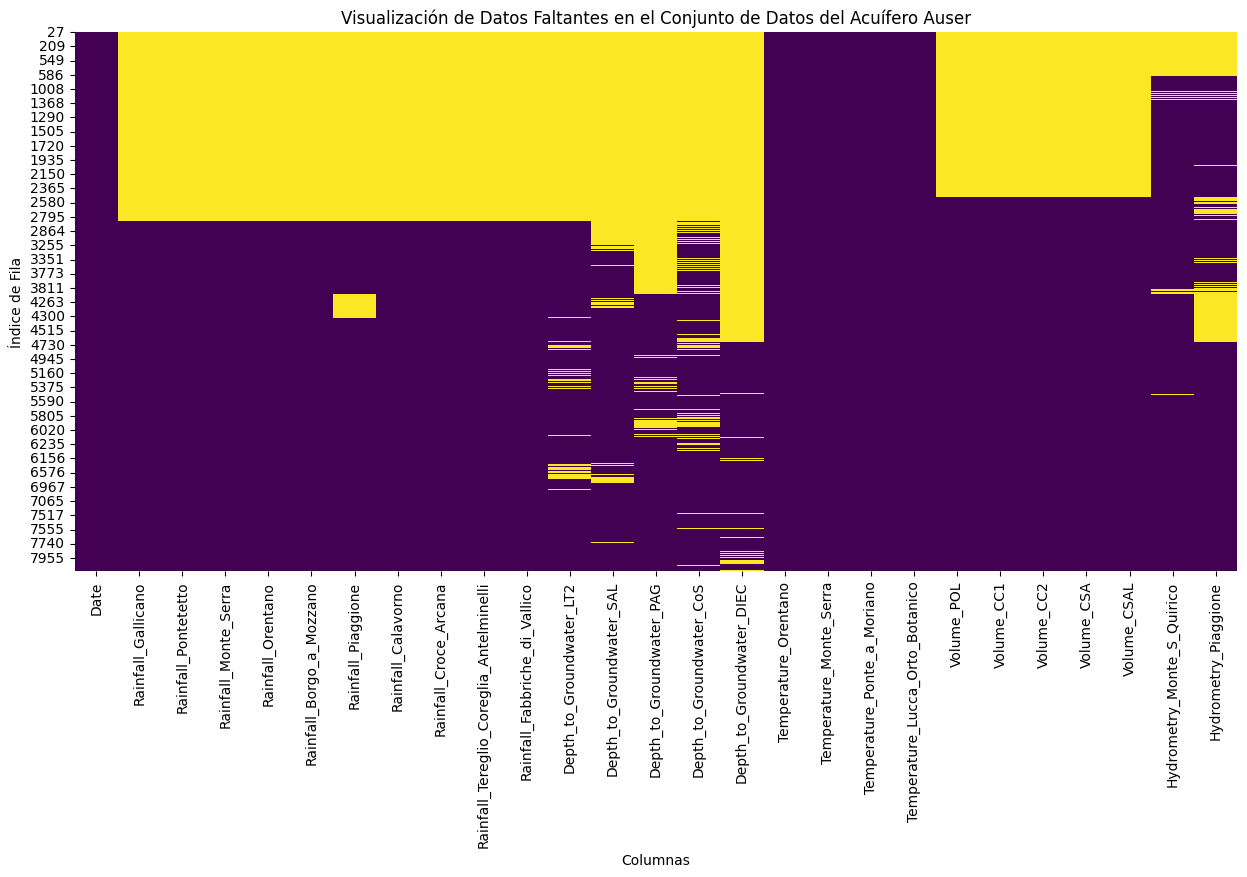

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna 'Date' en datetime
auser_data['Date'] = pd.to_datetime(auser_data['Date'], format='mixed')

# Ordenar los datos por fecha
auser_data.sort_values('Date', inplace=True)

# Visualización de datos faltantes
plt.figure(figsize=(15, 7))
sns.heatmap(auser_data.isnull(), cbar=False, cmap='viridis')
plt.title('Visualización de Datos Faltantes en el Conjunto de Datos del Acuífero Auser')
plt.xlabel('Columnas')
plt.ylabel('Índice de Fila')
plt.show()


Observaciones Clave:
Precipitación: Las columnas de precipitación tienen muchos valores en 0, lo cual es típico, pero sus valores máximos varían significativamente, indicando eventos de lluvias intensas. La distribución de estos valores sugiere que podría ser útil considerar métodos de transformación o normalización para modelar estos datos de manera efectiva.
Profundidad del Agua Subterránea: Las columnas que miden la profundidad del agua subterránea (Depth_to_Groundwater) varían considerablemente, lo que indica que los niveles del agua en diferentes puntos son muy variables a lo largo del tiempo. Estas son probablemente las variables objetivo para tus modelos de predicción.
Temperatura: Las temperaturas tienen un rango esperado y no presentan valores inusuales, lo que indica que los datos están bien mantenidos y podrían ser útiles para explicar variaciones estacionales en las características del agua.
Volúmenes y Hidrometría: Estos datos, cuando están disponibles, probablemente también sean cruciales para el modelado, aunque algunos presentan una gran cantidad de valores cero, lo que podría necesitar ser evaluado en términos de su utilidad o necesidad de imputación

In [9]:
# Generar estadísticas descriptivas para cada columna
auser_data_description = auser_data.describe()

# Mostrar las estadísticas descriptivas
auser_data_description



,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
count,8154,5295.000000,5295.000000,5289.000000,5295.000000,5295.000000,4930.000000,5295.000000,5295.000000,5295.000000,...,8154.000000,8154.000000,8154.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,7241.000000,6119.000000
mean,2009-05-02 20:36:01.589403904,4.948782,3.495449,3.919077,3.150670,4.578961,3.953976,4.578886,2.849745,4.182927,...,11.202079,10.971358,15.501134,-9316.138433,-16301.825866,-11808.085531,-2352.562424,-1985.775034,0.313618,-0.209204
min,1998-01-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.850000,-2.850000,-3.300000,-13883.225810,-18601.920000,-14438.304000,-7757.258065,-9497.774194,0.000000,-1.190000
25%,2003-10-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.650000,0.000000,9.750000,-11004.654450,-17081.280000,-12769.920000,-5493.709677,-4354.392857,0.160000,-1.000000
50%,2009-05-02 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.000000,10.875000,15.400000,-9728.571429,-16450.560000,-12078.720000,0.000000,0.000000,0.260000,-0.280000
75%,2014-11-30 18:00:00,2.000000,1.000000,1.600000,1.000000,2.000000,1.400000,2.000000,1.400000,2.000000,...,16.700000,18.550000,21.600000,-7323.783871,-15785.280000,-11015.136000,0.000000,0.000000,0.400000,0.580000
max,2020-12-06 00:00:00,318.800000,146.600000,152.200000,108.800000,176.600000,140.800000,209.000000,285.000000,147.200000,...,29.500000,30.750000,31.050000,-4114.670400,-7149.791935,-5569.298387,0.000000,0.000000,2.170000,3.690000
std,NaN,14.366480,9.983772,10.815270,8.747507,12.771166,10.888103,12.461918,9.239679,11.135511,...,6.903190,8.708626,7.138789,2224.435459,1490.096594,1444.085240,2854.176875,2534.301154,0.213851,0.849013


In [10]:
# Calcular el porcentaje de datos faltantes por columna
missing_percentage = auser_data.isnull().mean() * 100

# Filtrar columnas con más del 20% de datos faltantes
columns_to_drop = missing_percentage[missing_percentage > 20].index
auser_data_filtered = auser_data.drop(columns=columns_to_drop)

# Mostrar las columnas descartadas y el conjunto de datos resultante
columns_to_drop, auser_data_filtered.head()


(Index(['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra',
        'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
        'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
        'Rainfall_Tereglio_Coreglia_Antelminelli',
        'Rainfall_Fabbriche_di_Vallico', 'Depth_to_Groundwater_LT2',
        'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
        'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC', 'Volume_POL',
        'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL',
        'Hydrometry_Piaggione'],
       dtype='object'),
           Date  Temperature_Orentano  Temperature_Monte_Serra  \
 27  1998-01-04                   0.0                    13.60   
 57  1998-01-05                   0.0                    11.00   
 88  1998-01-06                   0.0                    15.55   
 118 1998-01-07                   0.0                    22.55   
 149 1998-01-08                   0.0                    23.40   
 
      

/tmp/ipykernel_531/970625949.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  auser_data_filtered['Hydrometry_Monte_S_Quirico'].fillna(median_hydrometry, inplace=True)


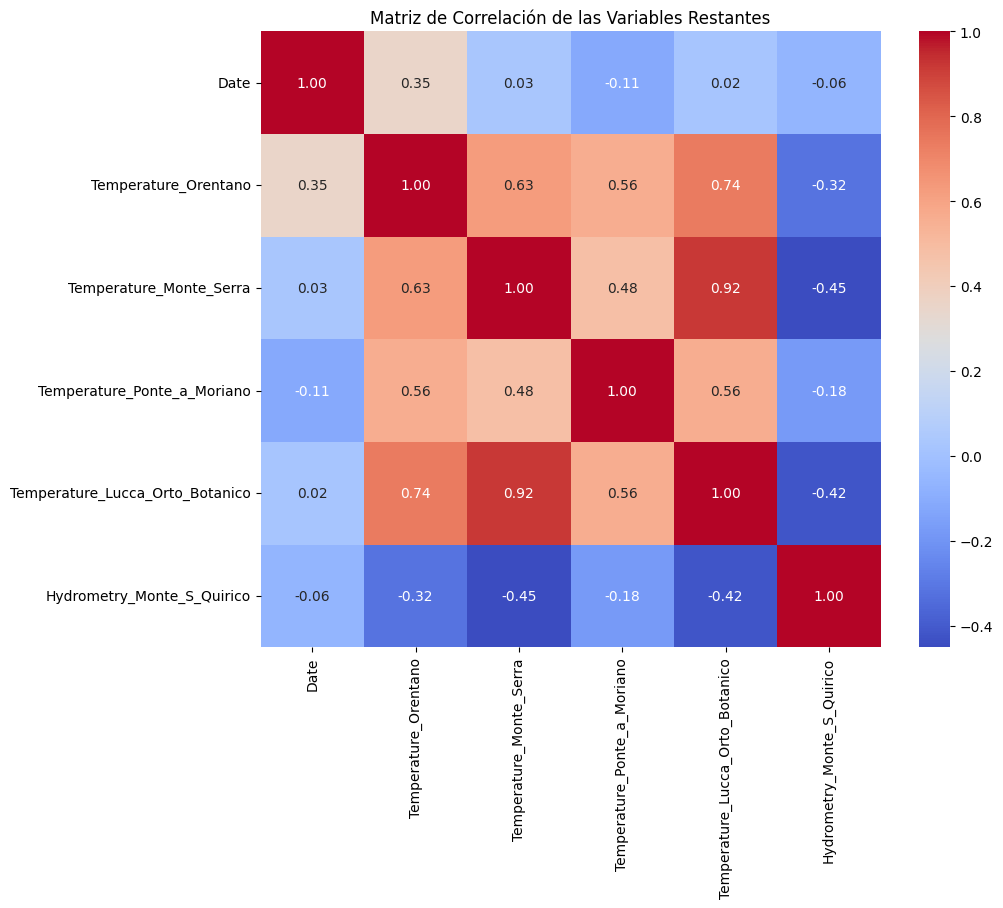

In [11]:
# Imputar los valores faltantes en 'Hydrometry_Monte_S_Quirico' con la mediana
median_hydrometry = auser_data_filtered['Hydrometry_Monte_S_Quirico'].median()
auser_data_filtered['Hydrometry_Monte_S_Quirico'].fillna(median_hydrometry, inplace=True)

# Realizar un análisis de correlación
correlation_matrix = auser_data_filtered.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de las Variables Restantes')
plt.show()


Observaciones:
Temperaturas entre Ubicaciones: Hay una fuerte correlación entre las temperaturas registradas en diferentes ubicaciones, lo cual es esperado dado que están geográficamente cercanas y experimentan patrones climáticos similares.
Temperatura y Hidrometría: Las correlaciones entre las temperaturas y la hidrometría son relativamente bajas, lo que sugiere que las temperaturas solas pueden no ser suficientemente predictivas para la hidrometría en este conjunto de datos. Sin embargo, podrían contribuir a un modelo combinado con otras variables.

Como despues de eliminar las variables con mas del 20% de datos faltantes han quedado muy pocas variables vuevlvo a cargar el dataframe original y escojo solo algunas de las variables eliminadas por su importancia para la prediccion

In [32]:
pd.options.mode.copy_on_write = True
# Cargar nuevamente el conjunto de datos completo
auser_data_full = pd.read_csv('/workspaces/linea_temporal_alternativa/data/raw/Aquifer_Auser.csv')
auser_data_full['Date'] = pd.to_datetime(auser_data_full['Date'], format='mixed')

# Seleccionar columnas de precipitación y profundidad del agua subterránea
precipitation_columns = [col for col in auser_data_full.columns if 'Rainfall' in col]
groundwater_columns = [col for col in auser_data_full.columns if 'Depth_to_Groundwater' in col]

# Crear un nuevo DataFrame con las columnas seleccionadas y la fecha
auser_data_with_selected_features = auser_data_full[['Date'] + precipitation_columns + groundwater_columns]

# Imputación de los datos faltantes usando interpolación lineal
auser_data_with_selected_features.interpolate(method='linear', limit_direction='both', inplace=True)

# Verificar los resultados de la imputación
auser_data_with_selected_features.isnull().sum(), auser_data_with_selected_features.head()


(Date                                       0
 Rainfall_Gallicano                         0
 Rainfall_Pontetetto                        0
 Rainfall_Monte_Serra                       0
 Rainfall_Orentano                          0
 Rainfall_Borgo_a_Mozzano                   0
 Rainfall_Piaggione                         0
 Rainfall_Calavorno                         0
 Rainfall_Croce_Arcana                      0
 Rainfall_Tereglio_Coreglia_Antelminelli    0
 Rainfall_Fabbriche_di_Vallico              0
 Depth_to_Groundwater_LT2                   0
 Depth_to_Groundwater_SAL                   0
 Depth_to_Groundwater_PAG                   0
 Depth_to_Groundwater_CoS                   0
 Depth_to_Groundwater_DIEC                  0
 dtype: int64,
         Date  Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
 0 1998-05-03                37.2                 26.0                  21.4   
 1 1998-06-03                37.2                 26.0                  21.4   
 2 1998-0

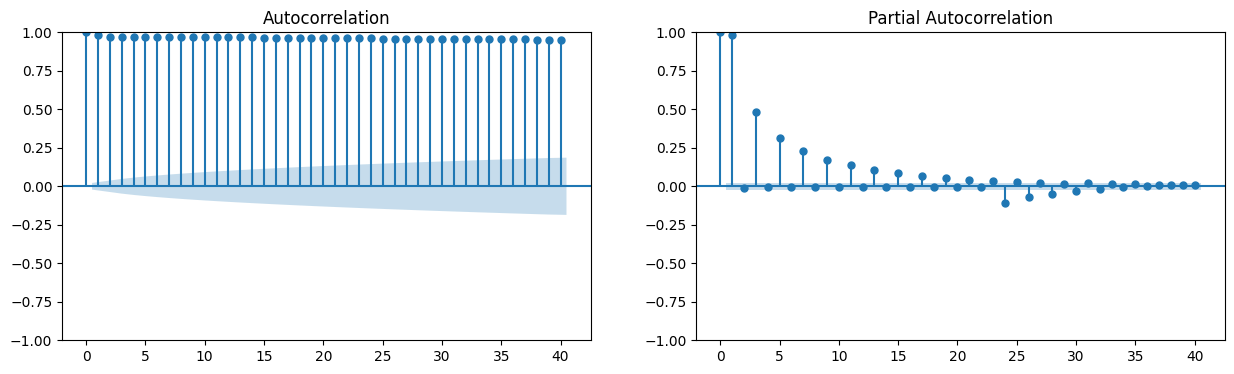

Test Statistic                   -0.472712
p-value                           0.897233
#Lags Used                       36.000000
Number of Observations Used    8117.000000
Critical Value (1%)              -3.431156
Critical Value (5%)              -2.861896
Critical Value (10%)             -2.566960
dtype: float64

In [33]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Extraer la serie de tiempo de profundidad del agua subterránea
groundwater_series = auser_data_with_selected_features['Depth_to_Groundwater_LT2'].dropna()

# Test de Dickey-Fuller para chequear estacionariedad
dickey_fuller_result = adfuller(groundwater_series)

# Mostrar los resultados del test de Dickey-Fuller
df_output = pd.Series(dickey_fuller_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for key, value in dickey_fuller_result[4].items():
    df_output[f'Critical Value ({key})'] = value

# Gráficos ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# ACF
plot_acf(groundwater_series, lags=40, ax=axes[0])

# PACF
plot_pacf(groundwater_series, lags=40, ax=axes[1])

plt.show()

df_output


In [34]:
# Suponiendo que `groundwater_series` es tu Serie de Pandas
differenced_series = groundwater_series.diff().dropna()  # Diferenciación de primer orden

# Test de Dickey-Fuller aumentado para comprobar estacionariedad
adf_result = adfuller(differenced_series)

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -13.88910615812077
p-value: 6.013443885307307e-26
Critical Value (1%): -3.4311560837610977
Critical Value (5%): -2.861896231960304
Critical Value (10%): -2.566959617516834


In [38]:
# Suponiendo que 'groundwater_series' es tu serie temporal completa

# Definir el tamaño del conjunto de entrenamiento (p.ej., 80% de los datos)
train_size = int(len(differenced_series) * 0.8)
train, test = differenced_series[:train_size], differenced_series[train_size:]
# Ahora puedes ajustar el modelo ARIMA solo en los datos de 'train' y evaluarlo en 'test'


In [39]:
from pmdarima import auto_arima

# Ajustar el modelo AutoARIMA
auto_arima_model = auto_arima(train, seasonal=True, trace=True,
                                 error_action='ignore', suppress_warnings=True)

# Imprimir el resumen del mejor modelo
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-30821.297, Time=3.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-29990.962, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-30204.985, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-30391.828, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-29991.296, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-30806.268, Time=5.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-30787.084, Time=3.58 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-30821.588, Time=1.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-30755.168, Time=1.03 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-30819.180, Time=1.89 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-30819.982, Time=2.67 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-30820.375, Time=1.87 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-30807.973, Time=2.67 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-30815.316, Time=14.31 sec
 ARI

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


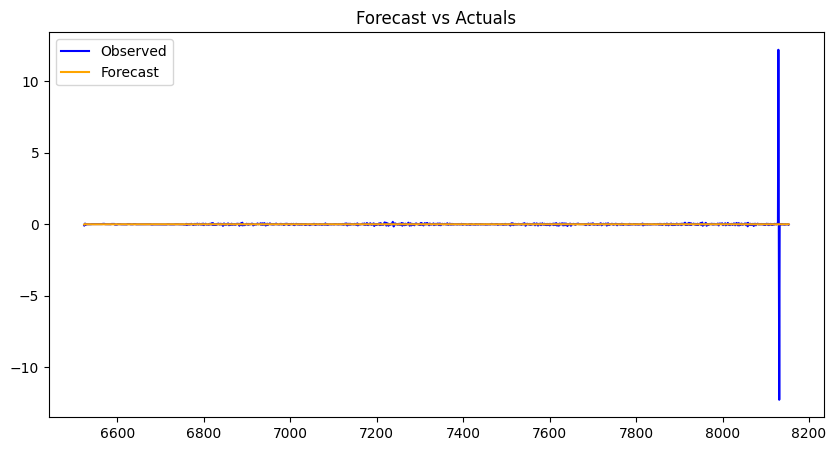

In [40]:
import matplotlib.pyplot as plt

# Predecir los valores futuros
predictions = auto_arima_model.predict(n_periods=len(test))


# Suponiendo que 'predictions' es tu serie de predicciones y 'test' es tu serie de datos de prueba
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Observed', color='blue')  # Asegúrate de que 'test' tiene un índice de fecha correcto
plt.plot(test.index, predictions, label='Forecast', color='orange')  # Asegúrate de que 'predictions' se alinee con el índice de 'test'
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

